In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("youssefaboelwafa/clustering-penguins-species")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/clustering-penguins-species


In [ ]:
dataset_path = '/root/.cache/kagglehub/datasets/youssefaboelwafa/clustering-penguins-species/versions/1/penguins.csv'

try:
    df = pd.read_csv(dataset_path)
    print("1")
except FileNotFoundError:
    print("0")
    raise

1


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as sch

import joblib

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [ ]:
df.isna().sum()

,0
culmen_length_mm,2
culmen_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,9


# Data Cleaning

In [ ]:
df = df.dropna(how='all')

In [ ]:
# Handle missing values
num_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
cat_cols = ['sex']

In [ ]:
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

In [ ]:
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [ ]:
# Check for outliers, remove extreme values
# Remove unrealistic values
df = df[(df['flipper_length_mm'] > 100) & (df['flipper_length_mm'] < 300)]
df = df[(df['body_mass_g'] > 2000) & (df['body_mass_g'] < 7000)]

In [ ]:
# Encode sex to numerical (0 for FEMALE, 1 for MALE, 2 for NA/other)
df['sex'] = df['sex'].map({'FEMALE': 0, 'MALE': 1, 'NA': 2, '.': 2}).fillna(2).astype(int)

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[num_cols])
df_scaled = pd.DataFrame(scaled_features, columns=num_cols)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   340 non-null    float64
 1   culmen_depth_mm    340 non-null    float64
 2   flipper_length_mm  340 non-null    float64
 3   body_mass_g        340 non-null    float64
 4   sex                340 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 15.9 KB


In [ ]:
df.isna().sum()

,0
culmen_length_mm,0
culmen_depth_mm,0
flipper_length_mm,0
body_mass_g,0
sex,0


In [ ]:
print(df[num_cols].describe())

       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        340.000000       340.000000         340.000000   340.000000
mean          43.955000        17.130588         200.955882  4201.029412
std            5.451108         1.961880          14.089719   804.240035
min           32.100000        13.100000         172.000000  2700.000000
25%           39.275000        15.575000         190.000000  3550.000000
50%           44.500000        17.300000         197.000000  4025.000000
75%           48.500000        18.625000         213.250000  4756.250000
max           59.600000        21.500000         231.000000  6300.000000


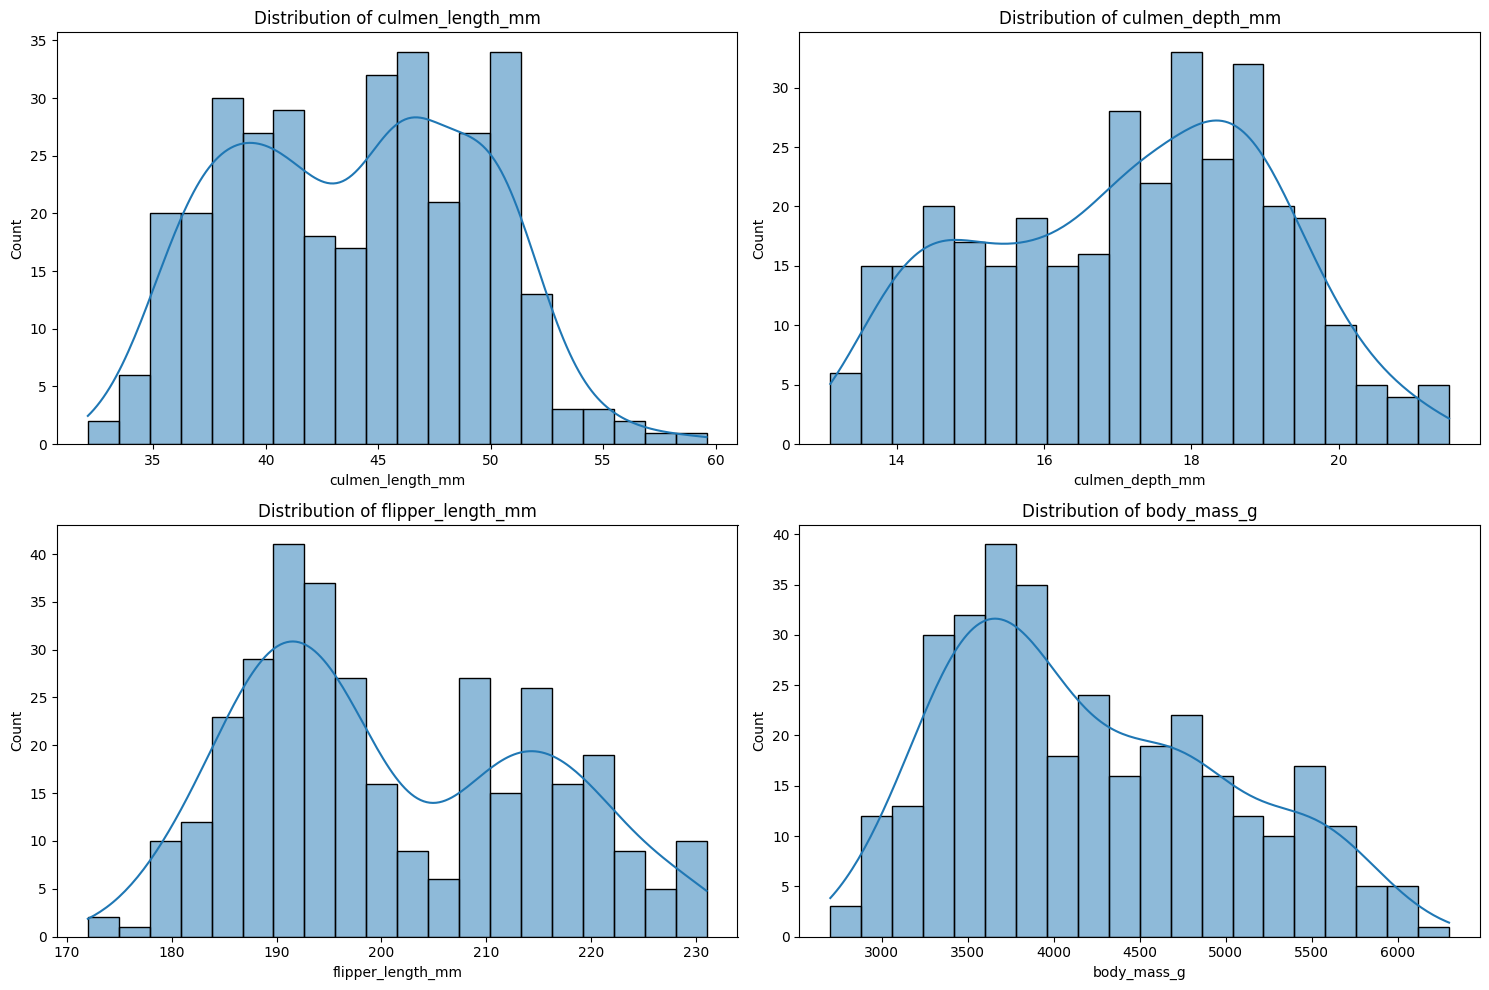

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

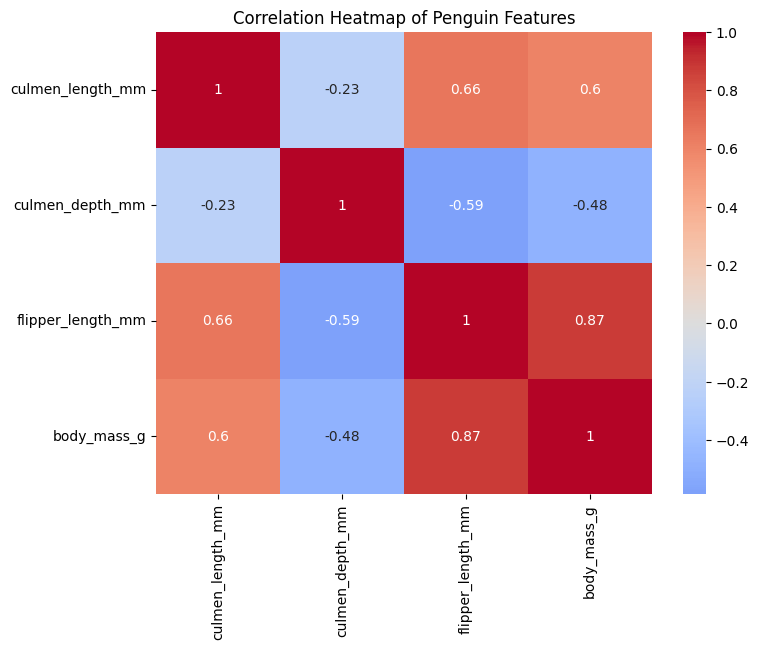

In [ ]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Penguin Features')
plt.show()

# Data Preprocessing

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[num_cols])
df_scaled = pd.DataFrame(scaled_features, columns=num_cols)

df_scaled.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,-0.891957,0.801132,-1.418431,-0.561641
1,-0.818470,0.137526,-1.063039,-0.499379
2,-0.671494,0.443806,-0.423334,-1.184262
3,-1.332884,1.107412,-0.565491,-0.935214
4,-0.855213,1.771018,-0.778726,-0.686165


# K-Means Clustering

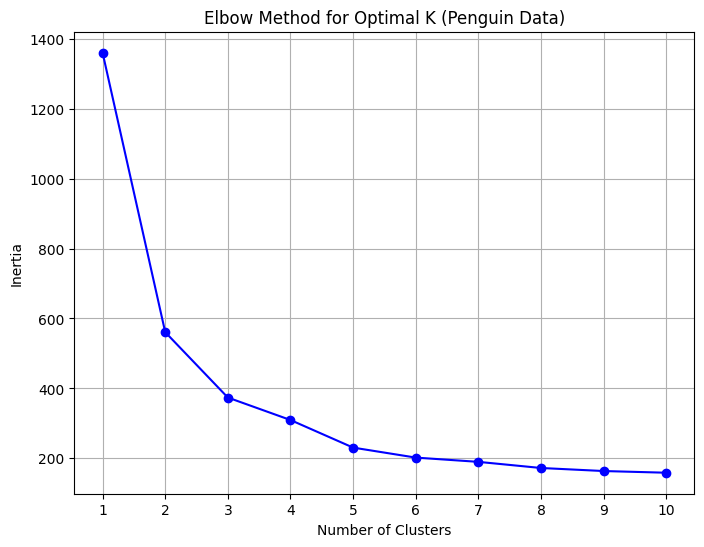

In [ ]:
data_scaled = df_scaled.values

inertia_values = []
range_n_clusters = range(1, 11)  # Testing cluster numbers from 1 to 10

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia_values, marker='o', color='b')
plt.title('Elbow Method for Optimal K (Penguin Data)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

In [ ]:
best_silhouette = -1
best_kmeans = None
best_n_clusters = 0

for n_clusters in range(2, 7):  # Trying cluster numbers from 2 to 6
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(data_scaled)

    silhouette_avg = silhouette_score(data_scaled, kmeans.labels_)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.4f}")

    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_kmeans = kmeans
        best_n_clusters = n_clusters

print(f"\nBest number of clusters: {best_n_clusters}")
print(f"Best Silhouette Score: {best_silhouette:.4f}")

Silhouette Score for 2 clusters: 0.5322
Silhouette Score for 3 clusters: 0.4508
Silhouette Score for 4 clusters: 0.4036
Silhouette Score for 5 clusters: 0.3764
Silhouette Score for 6 clusters: 0.3719

Best number of clusters: 2
Best Silhouette Score: 0.5322


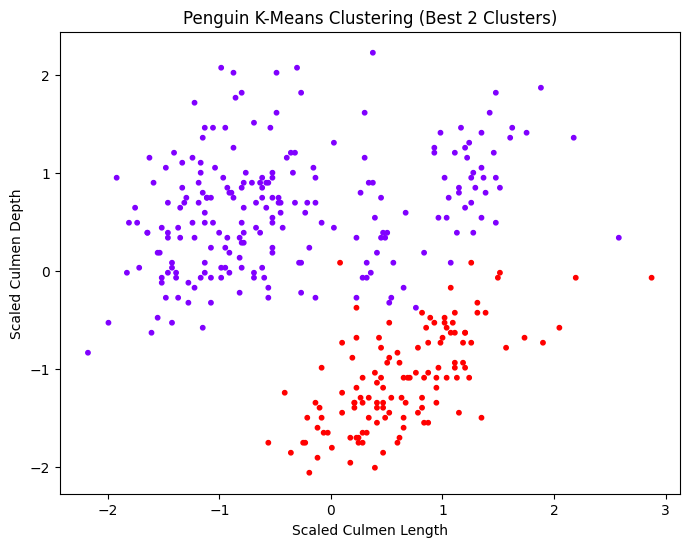

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=best_kmeans.labels_, cmap='rainbow', s=10)
plt.title(f'Penguin K-Means Clustering (Best {best_n_clusters} Clusters)')
plt.xlabel('Scaled Culmen Length')
plt.ylabel('Scaled Culmen Depth')
plt.show()

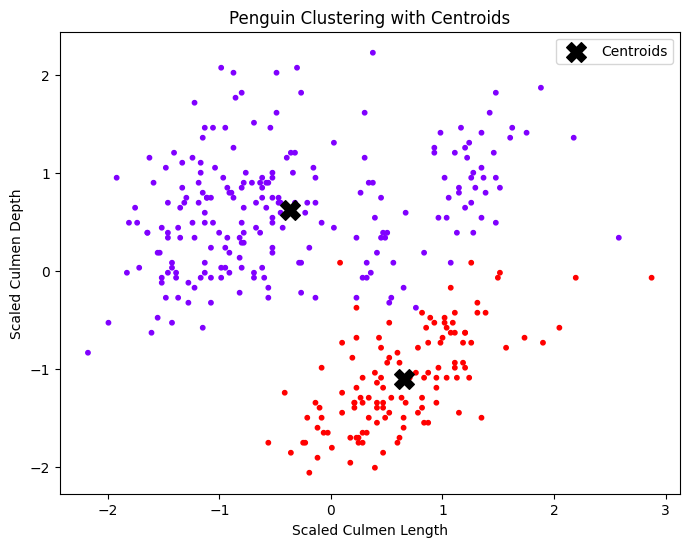

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=best_kmeans.labels_, cmap='rainbow', s=10)
centroids = best_kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='black', label='Centroids')
plt.title('Penguin Clustering with Centroids')
plt.xlabel('Scaled Culmen Length')
plt.ylabel('Scaled Culmen Depth')
plt.legend()
plt.show()

In [ ]:
df['cluster'] = best_kmeans.labels_

cluster_summary = df.groupby('cluster').mean()
print("\nK-Means Cluster Characteristics:")
print(cluster_summary)


K-Means Cluster Characteristics:
         culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
cluster                                                                      
0               41.942857        18.348387         191.755760  3705.069124   
1               47.504878        14.982114         217.186992  5076.016260   

              sex  agg_cluster  dbscan_cluster  
cluster                                         
0        0.506912          0.0       -0.009217  
1        0.536585          1.0        0.951220  


# Agglomerative Clustering

In [ ]:
best_silhouette_score = -1
best_n_clusters = 0
best_labels = None

for n_clusters in range(2, 6):
    print(f"\nEvaluating Agglomerative Clustering with {n_clusters} clusters")

    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agg_labels = agg_clustering.fit_predict(data_scaled)

    silhouette_avg = silhouette_score(data_scaled, agg_labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.4f}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters
        best_labels = agg_labels

print(f"\nBest number of clusters: {best_n_clusters}")
print(f"Best Silhouette Score: {best_silhouette_score:.4f}")


Evaluating Agglomerative Clustering with 2 clusters
Silhouette Score for 2 clusters: 0.5322

Evaluating Agglomerative Clustering with 3 clusters
Silhouette Score for 3 clusters: 0.4563

Evaluating Agglomerative Clustering with 4 clusters
Silhouette Score for 4 clusters: 0.4000

Evaluating Agglomerative Clustering with 5 clusters
Silhouette Score for 5 clusters: 0.3615

Best number of clusters: 2
Best Silhouette Score: 0.5322


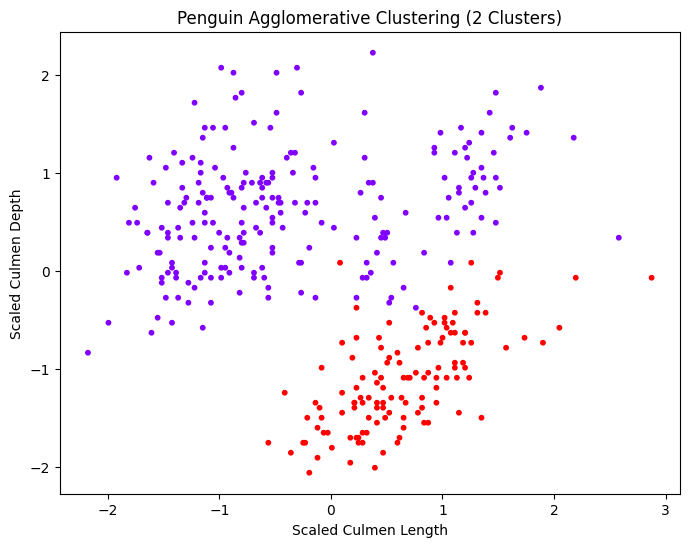

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=best_labels, cmap='rainbow', s=10)
plt.title(f'Penguin Agglomerative Clustering ({best_n_clusters} Clusters)')
plt.xlabel('Scaled Culmen Length')
plt.ylabel('Scaled Culmen Depth')
plt.show()

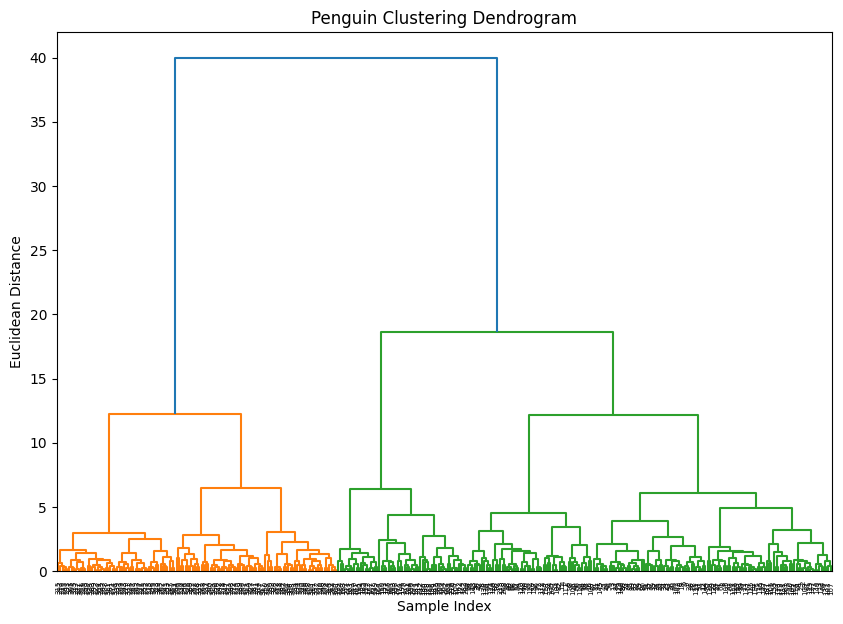

In [ ]:
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(data_scaled, method='ward'))
plt.title('Penguin Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.show()

In [ ]:
df['agg_cluster'] = best_labels

agg_cluster_summary = df.groupby('agg_cluster').mean()
print("\nAgglomerative Cluster Characteristics:")
print(agg_cluster_summary)


Agglomerative Cluster Characteristics:
             culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
agg_cluster                                                         
0                   41.942857        18.348387         191.755760   
1                   47.504878        14.982114         217.186992   

             body_mass_g       sex  cluster  
agg_cluster                                  
0            3705.069124  0.506912      0.0  
1            5076.016260  0.536585      1.0  


# DBSCAN CLustering

In [ ]:
eps_values = np.arange(0.3, 1.0, 0.1)
min_samples_values = range(3, 7)

best_silhouette_score = -1
best_eps = None
best_min_samples = None
best_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"\nEvaluating DBSCAN with eps={eps:.1f}, min_samples={min_samples}")

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            silhouette_avg = silhouette_score(data_scaled, labels)
            print(f"Silhouette Score: {silhouette_avg:.4f}")

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels
        else:
            print("Not enough clusters for Silhouette Score")

print("\n=== Best DBSCAN Parameters ===")
print(f"eps: {best_eps:.1f}")
print(f"min_samples: {best_min_samples}")
print(f"Silhouette Score: {best_silhouette_score:.4f}")


Evaluating DBSCAN with eps=0.3, min_samples=3
Silhouette Score: -0.3679

Evaluating DBSCAN with eps=0.3, min_samples=4
Silhouette Score: -0.4173

Evaluating DBSCAN with eps=0.3, min_samples=5
Silhouette Score: -0.4213

Evaluating DBSCAN with eps=0.3, min_samples=6
Not enough clusters for Silhouette Score

Evaluating DBSCAN with eps=0.4, min_samples=3
Silhouette Score: -0.1411

Evaluating DBSCAN with eps=0.4, min_samples=4
Silhouette Score: -0.0085

Evaluating DBSCAN with eps=0.4, min_samples=5
Silhouette Score: -0.1298

Evaluating DBSCAN with eps=0.4, min_samples=6
Silhouette Score: -0.1871

Evaluating DBSCAN with eps=0.5, min_samples=3
Silhouette Score: 0.3159

Evaluating DBSCAN with eps=0.5, min_samples=4
Silhouette Score: 0.1951

Evaluating DBSCAN with eps=0.5, min_samples=5
Silhouette Score: 0.2524

Evaluating DBSCAN with eps=0.5, min_samples=6
Silhouette Score: 0.2412

Evaluating DBSCAN with eps=0.6, min_samples=3
Silhouette Score: 0.4317

Evaluating DBSCAN with eps=0.6, min_samp

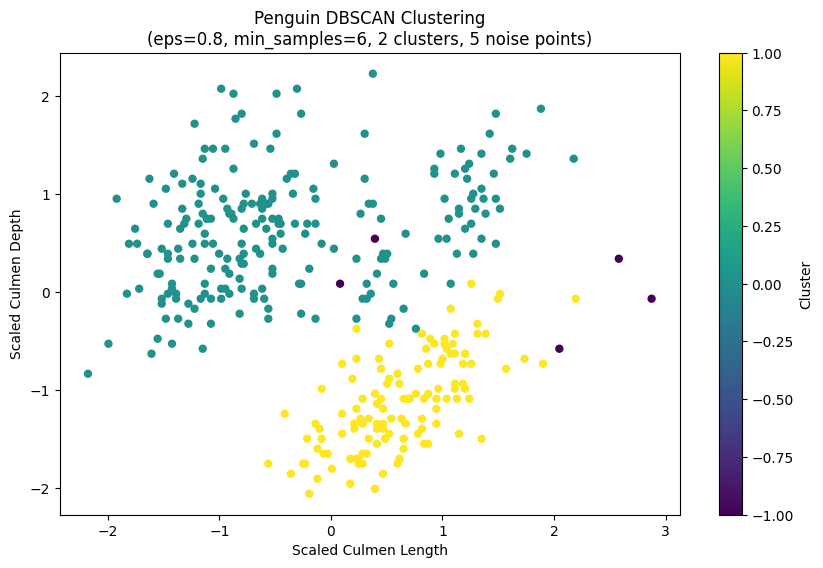


DBSCAN Cluster Characteristics (excluding noise):
                culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
dbscan_cluster                                                         
0                      41.848837        18.351628         191.869767   
1                      47.366667        14.937500         216.958333   

                body_mass_g       sex  cluster  agg_cluster  
dbscan_cluster                                               
0               3707.209302  0.511628      0.0          0.0  
1               5060.000000  0.525000      1.0          1.0  


In [ ]:
if best_labels is not None:
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(data_scaled[:, 0], data_scaled[:, 1],
                         c=best_labels, cmap='viridis', s=25)

    unique_labels = set(best_labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(best_labels).count(-1)

    plt.title(f'Penguin DBSCAN Clustering\n(eps={best_eps:.1f}, min_samples={best_min_samples}, '
              f'{n_clusters} clusters, {n_noise} noise points)')
    plt.xlabel('Scaled Culmen Length')
    plt.ylabel('Scaled Culmen Depth')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

    df['dbscan_cluster'] = best_labels

    dbscan_cluster_summary = df[df['dbscan_cluster'] != -1].groupby('dbscan_cluster').mean()
    print("\nDBSCAN Cluster Characteristics (excluding noise):")
    print(dbscan_cluster_summary)
else:
    print("No valid clustering found with tested parameters")

# Analysis
Result
- K-Means -> Best Cluster : 2, Best Silhouette Score : 0.5322, Clean separation into 2 distinct groups
- Agglomerative	-> Best Cluster : 2, Best Silhouette Score : 0.5322, Same with K-Means
- DBSCAN	-> Best Cluster 2 (with noise), Best Silhouette Score :	0.4857, Struggled with density variations


1. All methods agree on 2 main clusters

2. Best Clusters: 2 clusters (highest Silhouette Score = 0.5322)

3. K-Means, Agglomerative, and DBSCAN all produced similar 2-cluster structures.


4. Noise in DBSCAN: Some points were marked as noise, but clusters remained consistent.